In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import numpy as np
import os
import tensorflow as tf

In [2]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images(r"C:\saranAI\Deep learning\Dog vs cat\Dataset"))
data = []
labels = []

# Loop over the image paths
for imagePath in imagePaths:
    # Extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]

    # Load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    # Update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)

# Convert the labels from strings to vectors
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# Split the data into training and testing sets
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)


[INFO] loading images...


In [3]:
# Initialize the training data augmentation object with more aggressive augmentation
aug = ImageDataGenerator(
    rotation_range=30,     # Increased rotation range
    zoom_range=0.25,       # Increased zoom range
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,       # Increased shear range
    horizontal_flip=True,
    fill_mode="nearest")


In [4]:
# Load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

# Unfreeze the last 15 layers of the MobileNetV2 model for fine-tuning
for layer in baseModel.layers[:-15]:
    layer.trainable = False

# Construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)  # Increased neurons
headModel = Dropout(0.5)(headModel)
headModel = Dense(128, activation="relu")(headModel)  # Added an additional dense layer
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# Place the head FC model on top of the base model (this will become the actual model)
model = Model(inputs=baseModel.input, outputs=headModel)


In [5]:
print("[INFO] compiling model...")
INIT_LR = 1e-5  # Reduced learning rate
EPOCHS = 16    # Increased epochs
BS = 10

opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])


[INFO] compiling model...


In [6]:
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)
    

[INFO] training head...
Epoch 1/16
11/11 [==============================] - 8s 406ms/step - loss: 0.8954 - accuracy: 0.5000 - val_loss: 0.7553 - val_accuracy: 0.5357
Epoch 2/16
11/11 [==============================] - 4s 371ms/step - loss: 0.8303 - accuracy: 0.5490 - val_loss: 0.7309 - val_accuracy: 0.5714
Epoch 3/16
11/11 [==============================] - 4s 369ms/step - loss: 0.9196 - accuracy: 0.4902 - val_loss: 0.7085 - val_accuracy: 0.6429
Epoch 4/16
11/11 [==============================] - 4s 372ms/step - loss: 0.8936 - accuracy: 0.5294 - val_loss: 0.6904 - val_accuracy: 0.6786
Epoch 5/16
11/11 [==============================] - 4s 366ms/step - loss: 0.8010 - accuracy: 0.5196 - val_loss: 0.6742 - val_accuracy: 0.7143
Epoch 6/16
11/11 [==============================] - 4s 388ms/step - loss: 0.8081 - accuracy: 0.5545 - val_loss: 0.6586 - val_accuracy: 0.7500
Epoch 7/16
11/11 [==============================] - 4s 365ms/step - loss: 0.8314 - accuracy: 0.5098 - val_loss: 0.6427 - val

In [7]:
# Make predictions on the test set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# For each image in the testing set, we need to find the index of the label with the corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# Show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))


[INFO] evaluating network...
3/3 [==============================] - 1s 186ms/step
              precision    recall  f1-score   support

        cats       0.93      1.00      0.97        14
        dogs       1.00      0.93      0.96        14

    accuracy                           0.96        28
   macro avg       0.97      0.96      0.96        28
weighted avg       0.97      0.96      0.96        28



In [8]:
# Save the model to disk
print("[INFO] saving mask detector model...")
model.save("detector.model", save_format="h5")

[INFO] saving mask detector model...


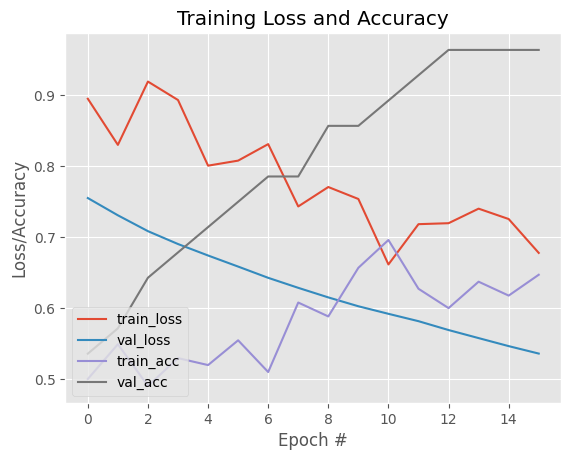

In [11]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

1/1 [==============================] - 1s 915ms/step


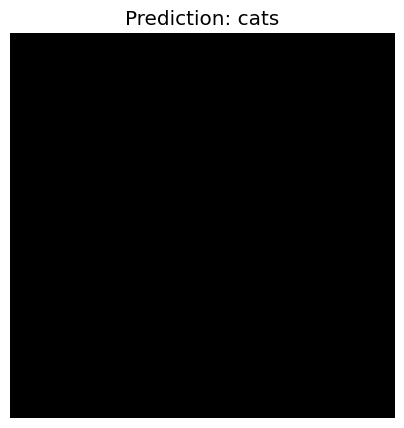

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Function to predict and plot an image
def predict_and_plot_image(image_array, model, class_names):
  # Preprocess the image
  img_array = np.expand_dims(image_array, axis=0)
  img_array /= 255.0

  # Predict the class
  prediction = model.predict(img_array)
  # Get the index of the class with the highest probability
  predicted_class_idx = np.argmax(prediction[0])
  class_label = class_names[predicted_class_idx]
  
  # Plot the image and prediction
  plt.figure(figsize=(5, 5))
  plt.imshow(image_array.astype('uint8'))
  plt.title(f'Prediction: {class_label}')
  plt.axis('off')
  plt.show()

# Function to load and predict the image
def load_and_predict_image(image_path, model, class_names):
  try:
      # Load the image
      img = image.load_img(image_path, target_size=(224, 224))
      img_array = image.img_to_array(img)
      predict_and_plot_image(img_array, model, class_names)
  except Exception as e:
      print(f"Error loading image: {e}")

# Load the model
model = load_model(r'C:\saranAI\Deep learning\Dog vs cat\detector.model')

# Example image path and class names
class_names = ['cats', 'dogs']  # Adjust this according to your classes
image_path = r'C:\saranAI\Deep learning\Dog vs cat\cat vs dog\cat_1.jpg'
load_and_predict_image(image_path, model, class_names)


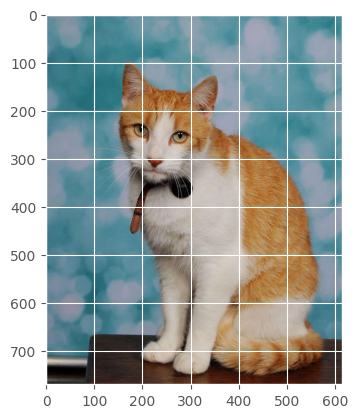

In [50]:
import matplotlib.pyplot as plt

img = plt.imread(image_path)
plt.imshow(img)
plt.show()


Image shape after loading: (224, 224, 3)
Image shape after preprocessing: (1, 224, 224, 3)
1/1 [==============================] - 1s 928ms/step


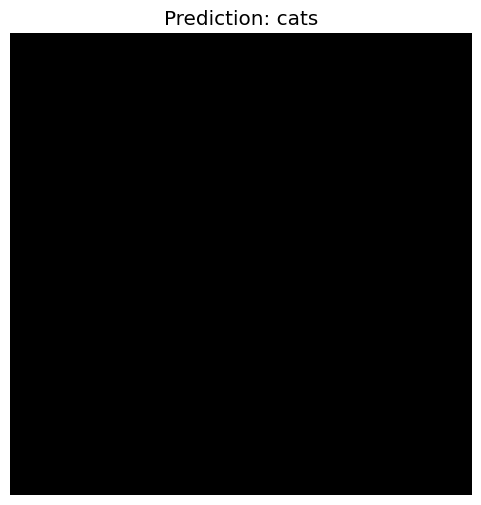

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

def predict_and_plot_image(image_array, model, class_names):
    # Preprocess the image
    img_array = np.expand_dims(image_array, axis=0)
    img_array /= 255.0

    print("Image shape after preprocessing:", img_array.shape)

    # Predict the class
    prediction = model.predict(img_array)
    predicted_class_idx = np.argmax(prediction[0])
    class_label = class_names[predicted_class_idx]

    plt.close('all')  # Close any existing plots
    plt.figure(figsize=(6, 6))
    plt.imshow(image_array.astype('uint8'))
    plt.title(f'Prediction: {class_label}')
    plt.axis('off')
    plt.show()

def load_and_predict_image(image_path, model, class_names):
    try:
        img = image.load_img(image_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        print("Image shape after loading:", img_array.shape)
        predict_and_plot_image(img_array, model, class_names)
    except Exception as e:
        print(f"Error loading image: {e}")

# Load the model
model = load_model(r'C:\saranAI\Deep learning\Dog vs cat\detector.model')

# Example image path and class names
class_names = ['cats', 'dogs']
image_path = r'C:\saranAI\Deep learning\Dog vs cat\cat vs dog\cat_1.jpg'
load_and_predict_image(image_path, model, class_names)


In [56]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Function to predict and plot an image
def predict_and_plot_image(image_array, model):
    # Preprocess the image
    img_array = np.expand_dims(image_array, axis=0)
    img_array /= 255.0

    # Predict the class
    prediction = model.predict(img_array)
    
    # Assuming binary classification with a sigmoid output
    class_label = 'dogs' if prediction[0] > 0.5 else 'cats'
    
    # Plot the image and prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(image_array.astype('uint8'))
    plt.title(f'Prediction: {class_label}')
    plt.axis('off')
    plt.show()

# Example usage
def load_and_predict_image(image_path, model):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    predict_and_plot_image(img_array, model)

# Load your model
model = load_model(r'C:\saranAI\Deep learning\Dog vs cat\detector.model')

# Example image path
image_path = r'C:\saranAI\Deep learning\Dog vs cat\cat vs dog\cat_1.jpg'
load_and_predict_image(image_path, model)


1/1 [==============================] - 1s 938ms/step


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

1/1 [==============================] - 1s 867ms/step


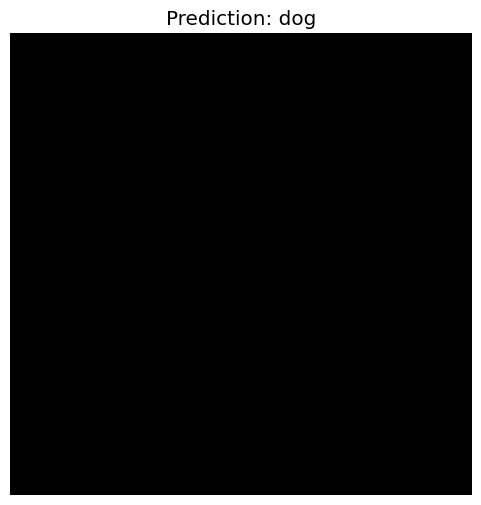

In [59]:
def predict_and_plot_image(image_array, model):
    img_array = np.expand_dims(image_array, axis=0)
    img_array /= 255.0

    # Predict the class (assuming softmax output)
    prediction = model.predict(img_array)
    
    # Get the index of the class with the highest probability
    predicted_class_idx = np.argmax(prediction[0])
    class_label = 'dog' if predicted_class_idx == 1 else 'cat'
    
    # Plot the image and prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(image_array.astype('uint8'))
    plt.title(f'Prediction: {class_label}')
    plt.axis('off')
    plt.show()


# Load your model
model = load_model(r'C:\saranAI\Deep learning\Dog vs cat\detector.model')

# Example image path
image_path = r'C:\saranAI\Deep learning\Dog vs cat\cat vs dog\dog_114.jpg'
load_and_predict_image(image_path, model)
